<img src="https://www.python.org/static/community_logos/python-logo-master-v3-TM.png" title="Python Logo"/>


<div class="alert alert-block alert-success">
    <em>Case Study: </em> <strong>Multi Classification with a weighted log-loss.</strong>
</div>

> __This is a case study of a multinomial classification.__

<div class="alert alert-block alert-info">
    <em>Part 0: </em> <strong>Packages Import and functions declaration.</strong>
</div>

> __In this section, all the needed packages are imported and the used functions are declared.__

In [2]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import backend as K

In [3]:
# declare functions
def compute_missing_rates(df):
    """Generate a dataframe with two column:
    column 1: column name in the dataframe
    column 2: missing rate in the corresponding column
    Parameters
    ----------
    df : DataFrame
        input DataFrame

    Returns
    -------
    DataFrame with the missing rates
    """
    df1 = df.isnull().mean().round(4) * 100
    return pd.DataFrame({'column':df1.index, 'missing_rate(%)':df1.values})

def confusion_mat(df: pd.DataFrame, col1: str, col2: str):
    """
    Given a dataframe with at least two categorical columns, create a 
    confusion matrix using percentages

    """
    return (df.groupby([col1, col2]).size().unstack(fill_value=0) / len(df) * 100)

def cramers_v(confusion_mat):
    """ calculate Cramers V statistic for categorial-categorial association.

    """
    chi2 = ss.chi2_contingency(confusion_mat)[0]
    n = confusion_mat.sum()
    phi2 = chi2 / n
    r, k = confusion_mat.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

<div class="alert alert-block alert-info">
    <em>Part 1: </em> <strong> EDA: "Exploratory data analysis".</strong>
</div>

> __This step consists in the exploration of the data. Two datatsets were provided: train and test datasets. The following steps are implemented below:__ <br>
> 1. Display size, head of datframes and columns types unsing "info". <br>
> 2. Check the data quality of dataframes by computing missing rates by column. <br>
> 

In [4]:
# import train and test data 
df_train = pd.read_csv("./data/train.csv", parse_dates=["creation_date_answer", "creation_date_global",\
                       "creation_date_request"])
df_test = pd.read_csv("./data/test.csv", parse_dates=["creation_date_answer", "creation_date_global",\
                       "creation_date_request"])

# EDA of train dataset 
print("The shape of the train dataset is: ", df_train.shape)
display(df_train.head())
display(df_train.info())

# EDA of test dataset 
print("The shape of the test dataset is: ", df_test.shape)
display(df_test.head())
display(df_test.info())

The shape of the train dataset is:  (25000, 24)


,id,AP,creation_date_answer,situation,ctc,location,gc_id,gc_label,creation_date_global,id_group,...,fruits_or_vegetables,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,ville,green_vegetables,vegetable_type,target
0,a46cfa61ea20a,f,2019-03-13 11:14:42.549,-1,NaN,52,70,G,2019-01-17 10:50:57.767,2d7e206d46ea1,...,NaN,-1,812a43d710ace,2019-03-13 11:14:42.549,football,aa8f4934a31eb,NaN,f,NaN,0
1,c3d0cb8f0c5e2,f,2019-03-21 14:27:32.441,-1,NaN,78,10,A,2018-08-20 05:57:51.038,35e96d6848871,...,NaN,-1,4b59257f24573,2019-03-21 14:27:32.441,football,6ff9ea9ec85fd,NaN,f,NaN,1
2,05dfbe0ec3a8b,f,2019-03-15 17:49:50.670,-1,NaN,70,10,A,2018-12-20 13:45:51.752,ffaf8085e383d,...,NaN,-1,f1a838f0d194b,2019-03-15 17:49:50.670,football,6a49a0a97b049,NaN,f,NaN,0
3,952e869ee1076,f,2019-01-07 08:19:29.114,-1,f,84,10,A,2018-07-21 10:28:49.386,5360cf0a40ce3,...,NaN,0,c3196847d1c14,2019-01-07 08:19:29.114,football,d0dcf1ca1bf04,NaN,f,NaN,1
4,5bd0e71b1395b,f,2019-02-03 17:57:22.926,-1,NaN,29,20,D,2018-12-07 19:59:26.968,126c3211f23fc,...,NaN,-1,70e18c6fe58cd,2019-02-03 17:57:22.926,football,b4870b1c8eb42,NaN,f,NaN,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     25000 non-null  object        
 1   AP                     25000 non-null  object        
 2   creation_date_answer   25000 non-null  datetime64[ns]
 3   situation              25000 non-null  int64         
 4   ctc                    9620 non-null   object        
 5   location               25000 non-null  int64         
 6   gc_id                  25000 non-null  int64         
 7   gc_label               25000 non-null  object        
 8   creation_date_global   25000 non-null  datetime64[ns]
 9   id_group               25000 non-null  object        
 10  id_group_2             25000 non-null  object        
 11  favorite_fruit         25000 non-null  object        
 12  fruit_situation_id     25000 non-null  int64         
 13  f

None

The shape of the test dataset is:  (25000, 23)


,id,AP,creation_date_answer,situation,ctc,location,gc_id,gc_label,creation_date_global,id_group,...,fruit_situation_label,fruits_or_vegetables,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,ville,green_vegetables,vegetable_type
0,cb7a4e0dd0777,f,2019-03-13 07:00:52.562,30,NaN,100,40,B,2019-03-13 07:03:13.632,b6a3d931cbbaf,...,jzy,t,1,bc3a12cac647f,2019-03-13 07:00:52.562,football,b78bd3c9f945c,Saint-Leu,f,NaN
1,e78e3915f3e30,f,2019-01-07 13:45:55.741,-1,f,95,40,B,2018-12-18 18:28:41.942,1b35749232404,...,hetz,t,1,79aa2c96bd0fc,2019-01-07 13:45:55.741,football,6fed1653be26d,Créteil,f,NaN
2,8e65ba155f983,f,2019-01-25 14:01:07.041,-1,f,34,20,D,2018-01-17 13:12:05.124,8f7612ff2c9cc,...,ag,NaN,-1,4b634a698cc8e,2019-01-25 14:01:07.041,football,fb7b5da2ef839,Bordeaux,f,NaN
3,701e90ca03ce2,f,2019-01-16 14:35:11.432,10,f,45,40,B,2018-11-07 13:21:33.877,2e3620e03b5f3,...,ag,NaN,2,cccd30d947857,2019-01-16 14:35:11.432,football,3a230e52fb02e,Saint-Herblain,f,NaN
4,768fefec8609a,f,2019-02-11 14:25:37.331,10,f,95,100,H,2018-10-16 10:17:01.716,ac19c1e8abd0d,...,hetz,f,2,62769fb7addda,2019-02-11 14:25:37.331,football,94c376f28ea60,Drancy,f,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     25000 non-null  object        
 1   AP                     25000 non-null  object        
 2   creation_date_answer   25000 non-null  datetime64[ns]
 3   situation              25000 non-null  int64         
 4   ctc                    9853 non-null   object        
 5   location               25000 non-null  int64         
 6   gc_id                  25000 non-null  int64         
 7   gc_label               25000 non-null  object        
 8   creation_date_global   25000 non-null  datetime64[ns]
 9   id_group               25000 non-null  object        
 10  id_group_2             25000 non-null  object        
 11  favorite_fruit         25000 non-null  object        
 12  fruit_situation_id     25000 non-null  int64         
 13  f

None

,column,missing_rate(%)
0,id,0.00
1,AP,0.00
2,creation_date_answer,0.00
3,situation,0.00
4,ctc,61.52
5,location,0.00
6,gc_id,0.00
7,gc_label,0.00
8,creation_date_global,0.00
9,id_group,0.00


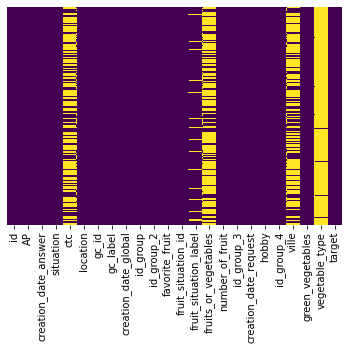

In [5]:
# check the data quality through missing rate computing for train dataset 
display(compute_missing_rates(df_train))
sn.heatmap(df_train.isnull(), cbar=False, yticklabels=False, cmap='viridis')

,column,missing_rate(%)
0,id,0.00
1,AP,0.00
2,creation_date_answer,0.00
3,situation,0.00
4,ctc,60.59
5,location,0.00
6,gc_id,0.00
7,gc_label,0.00
8,creation_date_global,0.00
9,id_group,0.00


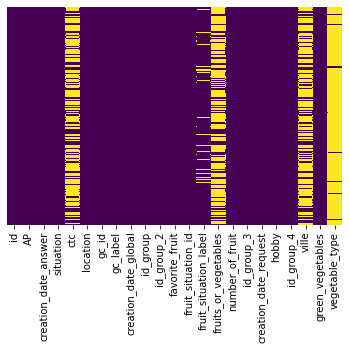

In [6]:
# check the data quality through missing rate computing for test dataset 
display(compute_missing_rates(df_test))
sn.heatmap(df_test.isnull(), cbar=False, yticklabels=False, cmap='viridis')

0    0.48308
1    0.35264
2    0.15496
3    0.00932
Name: target, dtype: float64

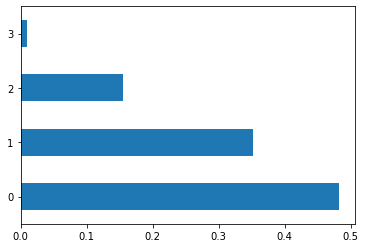

In [7]:
# Distribution of the target variable on train
display(df_train.target.value_counts(normalize=True))
df_train.target.value_counts(normalize=True).plot.barh()
plt.show()

In [8]:
# for each column, the values taken by this column are shown 
column_under_exploration = "vegetable_type"
display(df_train[column_under_exploration].value_counts())
display(df_test[column_under_exploration].value_counts())

green          227
salad          133
notsogreen      35
prettygreen     10
verygreen        5
almostgreen      4
Name: vegetable_type, dtype: int64

green          255
salad          138
notsogreen      31
prettygreen     16
verygreen        8
almostgreen      1
Name: vegetable_type, dtype: int64

<div class="alert alert-warning">
  <strong> Conclusion: </strong> <br>
    - Train dataset contains the input and target variables, athough test dataset contains only the input variables.<br>
    - variable types: <strong>categorical</strong> ("AP" {2 categories, 'f' and 't'}, "ctc" {2 categories,'f' and 't'}, "gc_label" {12 categories}, "favorite_fruit" {2 categories}, "fruit_situation_label" {21 categories}, "fruits_or_vegetables" {2 categories, 'f' and 't'}, "hobby" {3 categories}, "ville" {564(train)/543(test) categories}, "green_vegetables" {2 categories, 'f' and 't'}, "vegetable_type" {6 categories}), <strong>numerical</strong> ("situation", "location" {99 values with 3 extreme values}, "gc_id" {12 values}, "fruit_situation_id" {22 values}, "number_of_fruit" {9 values})<br>
    - Variables : "ctc", "fruits_or_vegetables", "ville", "vegetable_type" show high missing rates (more than 50%) on the both datasets. In addition, "fruit_situation_label" has a missing rate of 6.91% (moderate), also on the both datasets. Some actions should be taken, in order to either delete the columns or extract information from these columns by the creation of dummies integrating the missing information. <br>
    - Variables IDs : "id", "id_group", "id_group_2", "id_group_3", "id_group_4". These columns could be deleted a priori. <br>
    - Variables dates : "creation_date_answer", "creation_date_global", "creation_date_request". The two dates "creation_date_answer", "creation_date_request" seem to have the same dates. Further investigation should be done. Also, potential information could be extracted from the 3 dates: for instance computing the difference between the "creation_date_answer" / "creation_date_request" versus "creation_date_global" (this could lead to information about seniority or maturity of the account if applicable).  <br>
</div>


<div class="alert alert-block alert-info">
    <em>Part 2: </em> <strong> Data cleansing and data engineering.</strong>
</div>

> __This step consists in cleaning the data as follow:__ <br>
> 1. Create dummies integrating the information on missing data for variables : "ctc", "fruits_or_vegetables", "vegetable_type". However, for the variables "ville" and "fruit_situation_label" missing values will be encoded in a binary column and a frequency encoding will done in  a seperate column (rows with missing data will have the frequency of 0% to avoid a potential bias). The last choices were based on the number of existing categories in the variable. <br>
> 2. Binary encoding for the variables : "AP", "favorite_fruit", "green_vegetables". <br>
> 3. Dummies encoding for the variable : "hobby".
> 4. Frequency encoding for the variables : gc_label", "location", "fruit_situation_id"
> 5. Seniority or maturity in days is calculated between "creation_date_request" and "creation_date_global". <br>
> 6.  Delete IDs columns and "gc_id" (it is a duplicated column with "gc_label"). <br>


In [86]:
# Create copies for data cleaning
df_train_cleaned = df_train.copy()
df_test_cleaned = df_test.copy()

# Variables: "ville" and "fruit_situation_label", ecnoding of missing values
df_train_cleaned['ville_enc_nan'] = df_train_cleaned['ville'].notna().astype('uint8')
df_train_cleaned['fruit_situation_label_enc_nan'] = df_train_cleaned['fruit_situation_label'].notna().astype('uint8')
df_test_cleaned['ville_enc_nan'] = df_test_cleaned['ville'].notna().astype('uint8')
df_test_cleaned['fruit_situation_label_enc_nan'] = df_test_cleaned['fruit_situation_label'].notna().astype('uint8')

# Variables : "ctc", "fruits_or_vegetables", "vegetable_type", "ville" and "fruit_situation_label", fillna(0) 
df_train_cleaned[['ctc', 'fruits_or_vegetables', 'vegetable_type', 'fruit_situation_label', \
                  'ville']] = df_train_cleaned[['ctc', 'fruits_or_vegetables', 'vegetable_type', \
                                                'fruit_situation_label', 'ville']].fillna(0)
df_test_cleaned[['ctc', 'fruits_or_vegetables', 'vegetable_type', 'fruit_situation_label', \
                 'ville']] = df_test_cleaned[['ctc', 'fruits_or_vegetables', 'vegetable_type', \
                                              'fruit_situation_label', 'ville']].fillna(0)

# Variables: "ville" and "fruit_situation_label", frequency encoding
nbr_no_nan_ville = df_train['ville'].value_counts().sum()
enc_ville = (df_train_cleaned.groupby('ville').size()) / nbr_no_nan_ville
enc_ville[0] = 0.0
df_train_cleaned['ville_enc_freq'] = df_train_cleaned['ville'].apply(lambda x : enc_ville[x])
new_ville_list = list(set(df_test.ville.unique()) - set(df_train.ville.unique()))
new_ville = pd.Series([0.0]*len(new_ville_list), index=new_ville_list)
enc_ville = enc_ville.append(new_ville)
df_test_cleaned['ville_enc_freq'] = df_test_cleaned['ville'].apply(lambda x : enc_ville[x])

nbr_no_nan_fruit_situation_label = df_train['fruit_situation_label'].value_counts().sum()
enc_fruit_situation_label = (df_train_cleaned.groupby('fruit_situation_label').size()) / nbr_no_nan_fruit_situation_label
enc_fruit_situation_label[0] = 0.0
df_train_cleaned['fruit_situation_label_enc_freq'] = df_train_cleaned['fruit_situation_label'\
                                                                     ].apply(lambda x : enc_fruit_situation_label[x])
df_test_cleaned['fruit_situation_label_enc_freq'] = df_test_cleaned['fruit_situation_label'\
                                                                   ].apply(lambda x : enc_fruit_situation_label[x])

# Variables: "ctc", "fruits_or_vegetables", "vegetable_type", dummies encoding (including nan values)
df_train_cleaned = pd.get_dummies(df_train_cleaned, prefix=['ctc_', 'fruits_or_vegetables_', 'vegetable_type_'],\
                                  columns=['ctc', 'fruits_or_vegetables', 'vegetable_type'])
df_test_cleaned = pd.get_dummies(df_test_cleaned, prefix=['ctc_', 'fruits_or_vegetables_', 'vegetable_type_'],\
                                 columns=['ctc', 'fruits_or_vegetables', 'vegetable_type'])

# Variables : "AP", "favorite_fruit", "green_vegetables", binary encoding
df_train_cleaned['AP'] = np.where(df_train_cleaned['AP'] == 'f', 0, 1)
df_train_cleaned['favorite_fruit'] = np.where(df_train_cleaned['favorite_fruit'] == 'clementine', 0, 1)
df_train_cleaned['green_vegetables'] = np.where(df_train_cleaned['green_vegetables'] == 'f', 0, 1)
df_test_cleaned['AP'] = np.where(df_test_cleaned['AP'] == 'f', 0, 1)
df_test_cleaned['favorite_fruit'] = np.where(df_test_cleaned['favorite_fruit'] == 'clementine', 0, 1)
df_test_cleaned['green_vegetables'] = np.where(df_test_cleaned['green_vegetables'] == 'f', 0, 1)

# Variable : "hobby", dummies encoding
df_train_cleaned = pd.get_dummies(df_train_cleaned, prefix=['hobby_'], columns=['hobby'], drop_first=True)
df_test_cleaned = pd.get_dummies(df_test_cleaned, prefix=['hobby_'], columns=['hobby'], drop_first=True)

# Variables : "gc_label", "location", "fruit_situation_id", frequency encoding
enc_gc_label = (df_train_cleaned.groupby('gc_label').size()) / df_train_cleaned.shape[0]
df_train_cleaned['gc_label_enc_freq'] = df_train_cleaned['gc_label'].apply(lambda x : enc_gc_label[x]) 
df_test_cleaned['gc_label_enc_freq'] = df_test_cleaned['gc_label'].apply(lambda x : enc_gc_label[x]) 

enc_location = (df_train_cleaned.groupby('location').size()) / df_train_cleaned.shape[0]
df_train_cleaned['location_enc_freq'] = df_train_cleaned['location'].apply(lambda x : enc_location[x])
new_location_list = list(set(df_test.location.unique()) - set(df_train.location.unique()))
new_location = pd.Series([0.0]*len(new_location_list), index=new_location_list)
enc_location = enc_location.append(new_location)
df_test_cleaned['location_enc_freq'] = df_test_cleaned['location'].apply(lambda x : enc_location[x])

enc_fruit_situation_id = (df_train_cleaned.groupby('fruit_situation_id').size()) / df_train_cleaned.shape[0]
df_train_cleaned['fruit_situation_id_enc_freq'] = df_train_cleaned['fruit_situation_id'\
                                                                  ].apply(lambda x : enc_fruit_situation_id[x]) 
df_test_cleaned['fruit_situation_id_enc_freq'] = df_test_cleaned['fruit_situation_id'\
                                                                 ].apply(lambda x : enc_fruit_situation_id[x]) 

# Variables : "creation_date_request", "creation_date_answer", "creation_date_global", compute difference in days
df_train_cleaned['dates_diff'] = (df_train_cleaned['creation_date_request'] - df_train_cleaned['creation_date_global']).dt.days
df_test_cleaned['dates_diff'] = (df_test_cleaned['creation_date_request'] - df_test_cleaned['creation_date_global']).dt.days

# Variable : "target", dummies encoding
df_train_cleaned['target_dummies'] = df_train_cleaned['target']
df_train_cleaned = pd.get_dummies(df_train_cleaned, prefix=['target_'], columns=['target_dummies'])

# Extract information from dates
df_train_cleaned['date_request_year'] = df_train_cleaned['creation_date_request'].dt.year
df_train_cleaned['date_request_month'] = df_train_cleaned['creation_date_request'].dt.month
df_train_cleaned['date_request_day'] = df_train_cleaned['creation_date_request'].dt.day
df_train_cleaned['date_request_weekday'] = df_train_cleaned['creation_date_request'].dt.weekday
df_train_cleaned['date_request_hour'] = df_train_cleaned['creation_date_request'].dt.hour

df_test_cleaned['date_request_year'] = df_test_cleaned['creation_date_request'].dt.year
df_test_cleaned['date_request_month'] = df_test_cleaned['creation_date_request'].dt.month
df_test_cleaned['date_request_day'] = df_test_cleaned['creation_date_request'].dt.day
df_test_cleaned['date_request_weekday'] = df_test_cleaned['creation_date_request'].dt.weekday
df_test_cleaned['date_request_hour'] = df_test_cleaned['creation_date_request'].dt.hour

df_train_cleaned['date_global_year'] = df_train_cleaned['creation_date_global'].dt.year
df_train_cleaned['date_global_month'] = df_train_cleaned['creation_date_global'].dt.month
df_train_cleaned['date_global_day'] = df_train_cleaned['creation_date_global'].dt.day
df_train_cleaned['date_global_weekday'] = df_train_cleaned['creation_date_global'].dt.weekday
df_train_cleaned['date_global_hour'] = df_train_cleaned['creation_date_global'].dt.hour

df_test_cleaned['date_global_year'] = df_test_cleaned['creation_date_global'].dt.year
df_test_cleaned['date_global_month'] = df_test_cleaned['creation_date_global'].dt.month
df_test_cleaned['date_global_day'] = df_test_cleaned['creation_date_global'].dt.day
df_test_cleaned['date_global_weekday'] = df_test_cleaned['creation_date_global'].dt.weekday
df_test_cleaned['date_global_hour'] = df_test_cleaned['creation_date_global'].dt.hour

# Drop IDs and nan-dummies columns
df_train_cleaned = df_train_cleaned.drop(['id', 'id_group', 'id_group_2', 'id_group_3', 'id_group_4', 'ctc__0',\
                                          'fruits_or_vegetables__0', 'vegetable_type__0', 'gc_id', 'ville',\
                                          'fruit_situation_label', 'gc_label', 'location', 'fruit_situation_id',\
                                          'creation_date_global', 'creation_date_request', 'creation_date_answer'], axis=1)


In [87]:
df_train_cleaned.head(9)

,AP,situation,favorite_fruit,number_of_fruit,green_vegetables,target,ville_enc_nan,fruit_situation_label_enc_nan,ville_enc_freq,fruit_situation_label_enc_freq,...,date_request_year,date_request_month,date_request_day,date_request_weekday,date_request_hour,date_global_year,date_global_month,date_global_day,date_global_weekday,date_global_hour
0,0,-1,1,-1,0,0,0,1,0.000000,0.040091,...,2019,3,13,2,11,2019,1,17,3,10
1,0,-1,0,-1,0,1,0,1,0.000000,0.308998,...,2019,3,21,3,14,2018,8,20,0,5
2,0,-1,0,-1,0,0,0,1,0.000000,0.457674,...,2019,3,15,4,17,2018,12,20,3,13
3,0,-1,0,0,0,1,0,1,0.000000,0.308998,...,2019,1,7,0,8,2018,7,21,5,10
4,0,-1,0,-1,0,1,0,1,0.000000,0.308998,...,2019,2,3,6,17,2018,12,7,4,19
5,0,-1,0,-1,0,0,0,1,0.000000,0.457674,...,2019,3,20,2,12,2019,3,18,0,15
6,0,-1,1,-1,0,0,0,1,0.000000,0.457674,...,2019,1,17,3,15,2018,11,6,1,23
7,0,-1,0,0,0,0,1,1,0.058729,0.012032,...,2019,3,20,2,11,2017,12,20,2,16
8,0,-1,0,0,0,1,0,0,0.000000,0.000000,...,2019,2,20,2,8,2018,12,9,6,19


In [88]:
df_train_cleaned.describe()

,AP,situation,favorite_fruit,number_of_fruit,green_vegetables,target,ville_enc_nan,fruit_situation_label_enc_nan,ville_enc_freq,fruit_situation_label_enc_freq,...,date_request_year,date_request_month,date_request_day,date_request_weekday,date_request_hour,date_global_year,date_global_month,date_global_day,date_global_weekday,date_global_hour
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.0,25000.000000,25000.000000,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.003440,-0.347800,0.274120,-0.579080,0.017440,0.690520,0.323520,0.930880,0.007361,0.293478,...,2019.0,1.998320,15.692320,2.62896,12.30024,2018.295440,5.707880,15.652080,2.360440,12.662680
std,0.058552,3.950982,0.446079,0.858333,0.130907,0.761292,0.467829,0.253663,0.015744,0.176536,...,0.0,0.826816,8.632348,1.88038,4.17730,0.736055,4.273013,8.732922,1.807433,4.808099
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2019.0,1.000000,1.000000,0.00000,0.00000,2000.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.078249,...,2019.0,1.000000,8.000000,1.00000,9.00000,2018.000000,2.000000,8.000000,1.000000,10.000000
50%,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.308998,...,2019.0,2.000000,15.000000,3.00000,12.00000,2018.000000,4.000000,16.000000,2.000000,13.000000
75%,0.000000,-1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.002349,0.457674,...,2019.0,3.000000,23.000000,4.00000,15.00000,2019.000000,10.000000,23.000000,4.000000,16.000000
max,1.000000,70.000000,1.000000,7.000000,1.000000,3.000000,1.000000,1.000000,0.058729,0.457674,...,2019.0,3.000000,31.000000,6.00000,23.00000,2019.000000,12.000000,31.000000,6.000000,23.000000


<div class="alert alert-warning">
  <strong> Conclusion on the final list of variables : </strong> <br>
    - <strong>Binary variables :</strong> 'AP', 'favorite_fruit', 'green_vegetables', 'ville_enc_nan', 'fruit_situation_label_enc_nan', 'ctc__f', 'ctc__t', 'fruits_or_vegetables__f', 'fruits_or_vegetables__t', 'vegetable_type__almostgreen', 'vegetable_type__green', 'vegetable_type__notsogreen', 'vegetable_type__prettygreen', 'vegetable_type__salad', 'vegetable_type__verygreen', 'hobby__noball', 'hobby__volleyball'. <br>
    - <strong>Numerical variables :</strong> 'situation', 'number_of_fruit', 'ville_enc_freq', 'fruit_situation_label_enc_freq', 'gc_label_enc_freq', 'location_enc_freq', 'fruit_situation_id_enc_freq', 'dates_diff' <br> 
    - <strong>Timing variables : </strong>'date_request_year', 'date_request_month', 'date_request_day', 'date_request_weekday', 'date_request_hour'. <br>
    - <strong>Target.</strong> <br>
</div>

<div class="alert alert-block alert-info">
    <em>Part 3: </em> <strong> Data Viz.</strong>
</div>

In [89]:
numerical_vars_list = ['situation', 'number_of_fruit', 'ville_enc_freq', 'fruit_situation_label_enc_freq',\
                       'gc_label_enc_freq', 'location_enc_freq', 'fruit_situation_id_enc_freq', 'dates_diff']
binary_vars_list = ['AP', 'favorite_fruit', 'green_vegetables', 'ville_enc_nan', 'fruit_situation_label_enc_nan', 'ctc__f',\
                    'ctc__t', 'fruits_or_vegetables__f', 'fruits_or_vegetables__t', 'vegetable_type__almostgreen',\
                    'vegetable_type__green', 'vegetable_type__notsogreen', 'vegetable_type__prettygreen',\
                    'vegetable_type__salad', 'vegetable_type__verygreen', 'hobby__noball', 'hobby__volleyball']
timing_vars_list = ['date_request_year', 'date_request_month', 'date_request_day', 'date_request_weekday', 'date_request_hour',\
                   'date_global_year', 'date_global_month', 'date_global_day', 'date_global_weekday', 'date_global_hour']

situation                         0.001983
number_of_fruit                   0.037076
ville_enc_freq                   -0.037925
fruit_situation_label_enc_freq   -0.212205
gc_label_enc_freq                -0.060392
location_enc_freq                -0.063327
fruit_situation_id_enc_freq      -0.228768
dates_diff                        0.027347
target                            1.000000
Name: target, dtype: float64

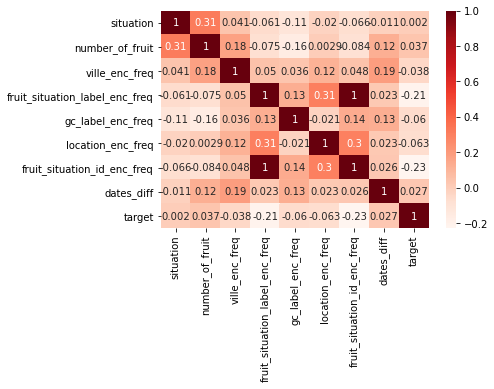

In [90]:
# Create a matrix using features and target
corr = df_train_cleaned[numerical_vars_list + ['target']].corr()
display(corr.target)

# Plot the correlation matrix
sn.heatmap(corr, annot=True, cmap = 'Reds')
plt.show()

In [82]:
# To understand the correlation of 1 between the two following variables 
df_train_cleaned[['fruit_situation_id_enc_freq', 'fruit_situation_label_enc_freq']]\
.loc[df_train_cleaned.fruit_situation_label_enc_freq==0]

,fruit_situation_id_enc_freq,fruit_situation_label_enc_freq
8,0.06912,0.0
32,0.06912,0.0
55,0.06912,0.0
66,0.06912,0.0
75,0.06912,0.0
...,...,...
24925,0.06912,0.0
24930,0.06912,0.0
24941,0.06912,0.0
24982,0.06912,0.0


date_request_year            NaN
date_request_month     -0.049506
date_request_day       -0.013912
date_request_weekday   -0.058590
date_request_hour      -0.108013
date_global_year       -0.084534
date_global_month       0.117298
date_global_day         0.026336
date_global_weekday     0.000864
date_global_hour       -0.021385
target                  1.000000
Name: target, dtype: float64

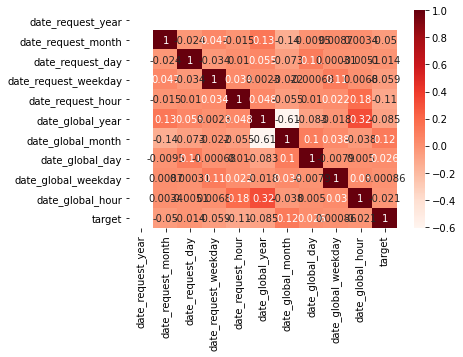

In [84]:
# Create a matrix using timing features and target
corr = df_train_cleaned[timing_vars_list + ['target']].corr()
display(corr.target)

# Plot the correlation matrix
sn.heatmap(corr, annot=True, cmap = 'Reds')
plt.show()

In [14]:
# Compute the confusion matrices between binary variables and target
for var in binary_vars_list:
    conf_matrix = pd.crosstab(df_train_cleaned.target, df_train_cleaned[var])
    print("The confusion matrix between, ", var, " and target in % (Cramer's V of ", cramers_v(conf_matrix.values), ") :")
    display(confusion_mat(df_train_cleaned, var, 'target'))

The confusion matrix between,  AP  and target in % (Cramer's V of  0.022634528733837 ) :


target,0,1,2,3
AP,,,,
0,48.176,35.076,15.472,0.932
1,0.132,0.188,0.024,0.000


The confusion matrix between,  favorite_fruit  and target in % (Cramer's V of  0.18286447336738845 ) :


target,0,1,2,3
favorite_fruit,,,,
0,33.960,28.936,9.284,0.408
1,14.348,6.328,6.212,0.524


The confusion matrix between,  green_vegetables  and target in % (Cramer's V of  0.06378434527779304 ) :


target,0,1,2,3
green_vegetables,,,,
0,47.556,34.856,14.964,0.880
1,0.752,0.408,0.532,0.052


The confusion matrix between,  ville_enc_nan  and target in % (Cramer's V of  0.017422546326228982 ) :


target,0,1,2,3
ville_enc_nan,,,,
0,32.212,24.108,10.696,0.632
1,16.096,11.156,4.800,0.300


The confusion matrix between,  fruit_situation_label_enc_nan  and target in % (Cramer's V of  0.06979761203532223 ) :


target,0,1,2,3
fruit_situation_label_enc_nan,,,,
0,4.232,1.840,0.780,0.060
1,44.076,33.424,14.716,0.872


The confusion matrix between,  ctc__f  and target in % (Cramer's V of  0.0 ) :


target,0,1,2,3
ctc__f,,,,
0,30.772,22.728,9.964,0.572
1,17.536,12.536,5.532,0.360


The confusion matrix between,  ctc__t  and target in % (Cramer's V of  0.05005129389108784 ) :


target,0,1,2,3
ctc__t,,,,
0,46.892,34.744,14.940,0.908
1,1.416,0.520,0.556,0.024


The confusion matrix between,  fruits_or_vegetables__f  and target in % (Cramer's V of  0.02375500518376101 ) :


target,0,1,2,3
fruits_or_vegetables__f,,,,
0,35.760,26.072,11.824,0.768
1,12.548,9.192,3.672,0.164


The confusion matrix between,  fruits_or_vegetables__t  and target in % (Cramer's V of  0.017908754036021997 ) :


target,0,1,2,3
fruits_or_vegetables__t,,,,
0,45.832,33.604,14.656,0.848
1,2.476,1.660,0.840,0.084


The confusion matrix between,  vegetable_type__almostgreen  and target in % (Cramer's V of  0.007157704125832161 ) :


target,0,1,2,3
vegetable_type__almostgreen,,,,
0,48.292,35.264,15.496,0.932
1,0.016,0.000,0.000,0.000


The confusion matrix between,  vegetable_type__green  and target in % (Cramer's V of  0.04098715362656574 ) :


target,0,1,2,3
vegetable_type__green,,,,
0,47.856,35.084,15.244,0.908
1,0.452,0.180,0.252,0.024


The confusion matrix between,  vegetable_type__notsogreen  and target in % (Cramer's V of  0.021009577329412502 ) :


target,0,1,2,3
vegetable_type__notsogreen,,,,
0,48.280,35.200,15.452,0.928
1,0.028,0.064,0.044,0.004


The confusion matrix between,  vegetable_type__prettygreen  and target in % (Cramer's V of  0.021031548832811744 ) :


target,0,1,2,3
vegetable_type__prettygreen,,,,
0,48.296,35.256,15.480,0.928
1,0.012,0.008,0.016,0.004


The confusion matrix between,  vegetable_type__salad  and target in % (Cramer's V of  0.04125958824207459 ) :


target,0,1,2,3
vegetable_type__salad,,,,
0,48.096,35.140,15.320,0.912
1,0.212,0.124,0.176,0.020


The confusion matrix between,  vegetable_type__verygreen  and target in % (Cramer's V of  0.0 ) :


target,0,1,2,3
vegetable_type__verygreen,,,,
0,48.300,35.260,15.488,0.932
1,0.008,0.004,0.008,0.000


The confusion matrix between,  hobby__noball  and target in % (Cramer's V of  0.023527916237272333 ) :


target,0,1,2,3
hobby__noball,,,,
0,48.292,35.184,15.476,0.932
1,0.016,0.080,0.020,0.000


The confusion matrix between,  hobby__volleyball  and target in % (Cramer's V of  0.013847935740917899 ) :


target,0,1,2,3
hobby__volleyball,,,,
0,47.648,34.896,15.284,0.932
1,0.660,0.368,0.212,0.000


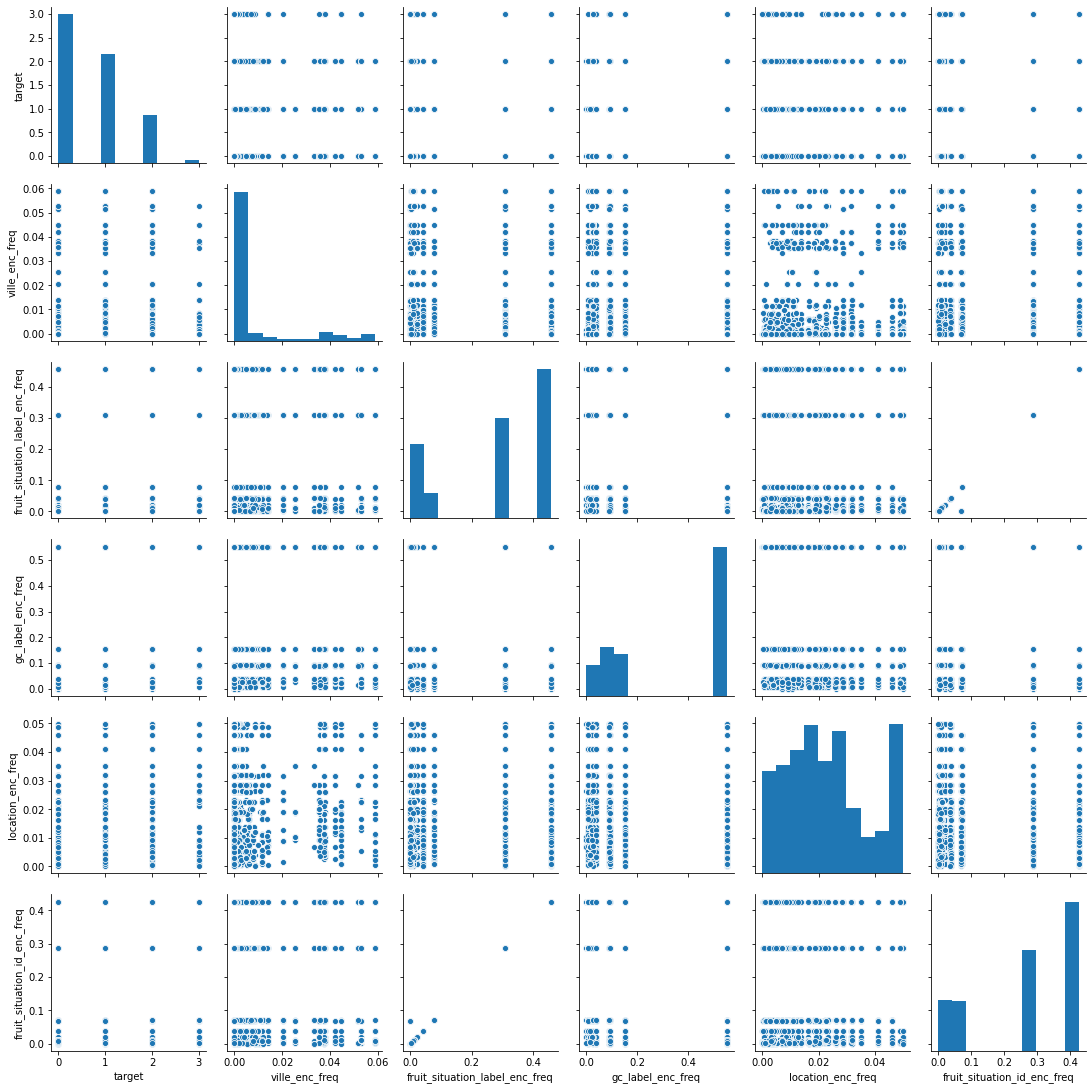

In [15]:
# Plot the pair plot of float features (frequencies) and target.
sn.pairplot(data = df_train_cleaned, vars=['target', 'ville_enc_freq','fruit_situation_label_enc_freq','gc_label_enc_freq',\
                                          'location_enc_freq', 'fruit_situation_id_enc_freq'])
plt.show()

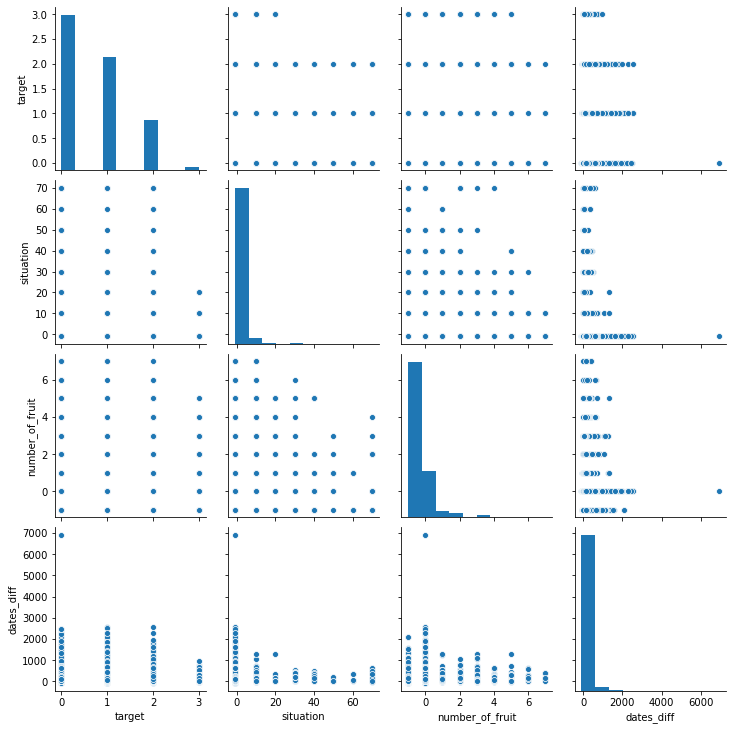

In [16]:
# Plot the pair plot of float features (others) and target.
sn.pairplot(data = df_train_cleaned, vars=['target', 'situation', 'number_of_fruit', 'dates_diff'])
plt.show()

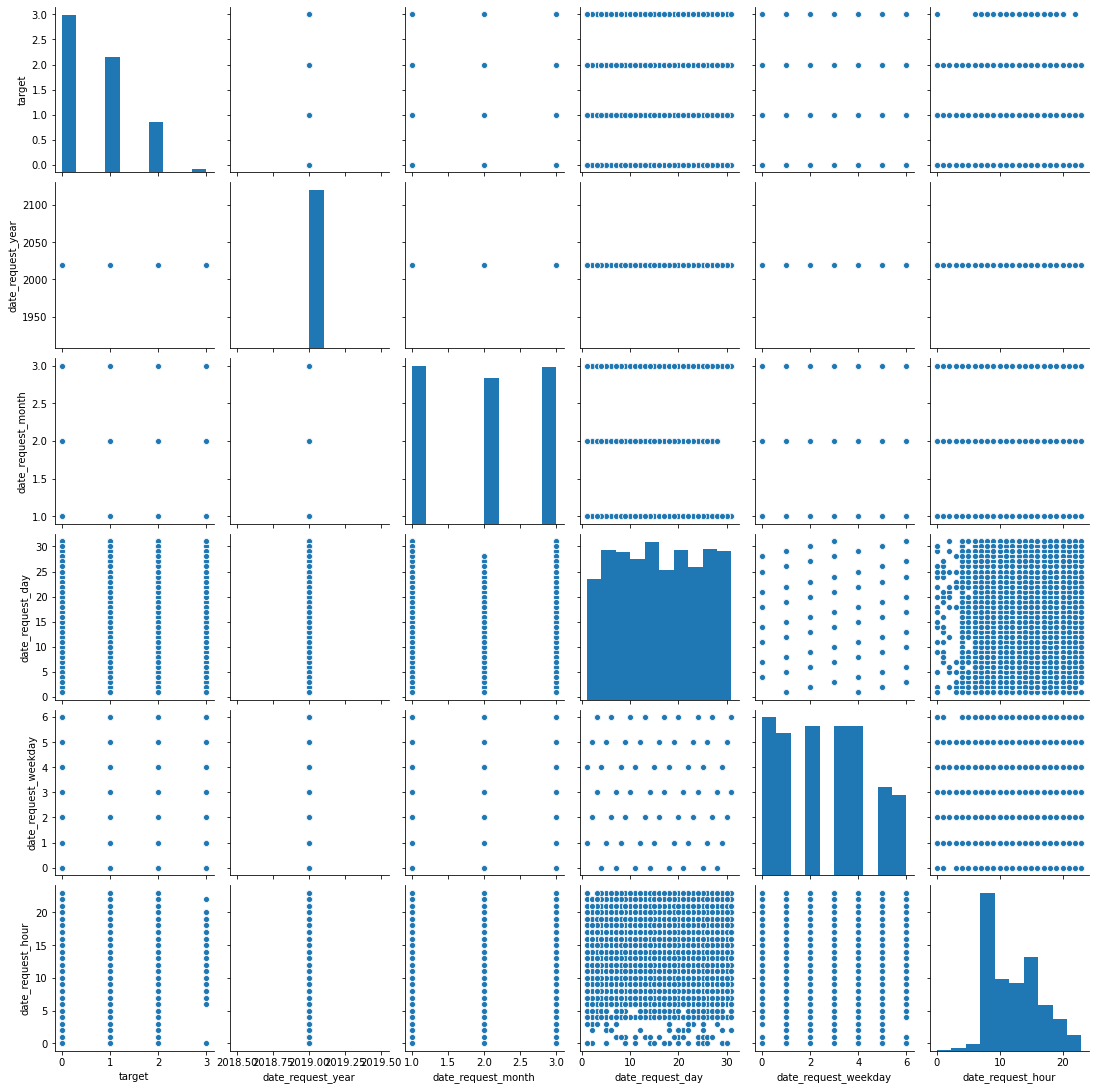

In [46]:
# Plot the pair plot of timing features (others) and target.
sn.pairplot(data = df_train_cleaned, vars=['target'] + timing_vars_list)
plt.show()

<div class="alert alert-warning">
  <strong> Conclusion: </strong> <br>
    - The generated frequency features do not show a high discriminatory power, except the feature <strong>"ville_enc_freq" and "dates_diff"</strong>. Also, <strong>"situation" and "number_of_fruit"  </strong>present some discriminatory power.<br>
    - Drop one of the duplicated variables :  <strong>'fruit_situation_id_enc_freq', 'fruit_situation_label_enc_freq'. </strong>  <br> 
    - The Cramer's V for binary variblaes do not also shows high discriminatory power.  <br>
    - The generated timing features do not show a high discriminatory power, except the feature <strong>"date_request_hour"</strong>.
</div>


> Feture Selection through correlation values (more than 5%):

In [92]:
selected_variables = ['fruit_situation_id_enc_freq', 'location_enc_freq', 'gc_label_enc_freq', 'date_request_weekday',\
                      'date_request_hour', 'date_global_year', 'date_global_month', 'favorite_fruit', 'green_vegetables',\
                      'fruit_situation_label_enc_nan', 'ctc__t']

<div class="alert alert-block alert-info">
    <em>Part 4: </em> <strong> Machine learning modelling.</strong>
</div>

> Let's apply this "weighted log-loss" to evaluate the models for a <strong>"multinomial classification" </strong> :<br>
    <br>
><font size="5">$Logloss = -(\frac{\sum_{i=1}^{4} weight_i * \sum_{j=1}^{Nclass_i} \frac{label_{ij}}{Nclass_i} * \ln{pred_{ij}}}{\sum_{i=1}^{4} weight_i})$</font>

> The implemented models for the multinomila classification will be : 
> 1. "Classifier Chain" (using logistic regression as benchmark model without using the weighted logloss as a cost function).<br> 
> 2. "Logistic Regression" with a weighted logloss (first with 80/20 split and then cross-validation (5 folds)).<br>

In [147]:
list_columns_to_exclude = ['date_request_year', 'date_global_year', 'fruit_situation_label_enc_freq', 'target', 'target__0',\
                           'target__1', 'target__2', 'target__3']
X_input = df_train_cleaned.loc[:, ~df_train_cleaned.columns.isin(list_columns_to_exclude)].values
#X_input = df_train_cleaned[selected_variables].values
Y_target = df_train_cleaned[['target', 'target__0', 'target__1', 'target__2', 'target__3']].values
normalizer = preprocessing.Normalizer().fit(X_input)
X_normalized = normalizer.transform(X_input)
X_normalized

# split the data into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_normalized, Y_target, test_size=0.2, random_state=0)

In [112]:
X_train.shape

(20000, 32)

In [113]:
# Let's create a function using the tensorflow computing power to calculate the last logloss function

# Parameters 
epsilon = 1e-7 
weights_arr = np.array([1, 10, 100, 1000], dtype='float64')
class_counts_train = np.array([Y_train[:,1].sum(), Y_train[:,2].sum(), Y_train[:,3].sum(), Y_train[:,4].sum()],\
                              dtype='float64')
class_counts_val = np.array([Y_val[:,1].sum(), Y_val[:,2].sum(), Y_val[:,3].sum(), Y_val[:,4].sum()],\
                              dtype='float64')
class_counts_all_train = np.array([Y_target[:,1].sum(), Y_target[:,2].sum(), Y_target[:,3].sum(), Y_target[:,4].sum()],\
                              dtype='float64')
K.set_floatx('float64') 

#  Weighted multiclass logloss
def weighted_log_loss(y_true, y_pred, class_counts):
    """
    This function permits to compute a weighted logloss 
    """
    y_pred_clipped = K.clip(y_pred, epsilon, 1-epsilon)  
    y_true_weighted = weights_arr * (y_true/class_counts)
    loss_num = (y_true_weighted * K.log(y_pred_clipped))
    loss = -1*K.sum(loss_num)/K.sum(weights_arr)
    
    return loss

> 1. "Classifier Chain" (using logistic regression).<br>

In [118]:
nbr_learners = 10
base_lr = LogisticRegression(solver='newton-cg')

# Fit an ensemble of logistic regression classifier chains and take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(nbr_learners)]
for chain in chains:
    chain.fit(X_train, Y_train[:,1:])

Y_pred_chains = np.array([chain.predict(X_val) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(Y_val[:,1:], Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    Y_val[:,1:], Y_pred_ensemble >= 0.5, average="samples"
)

11


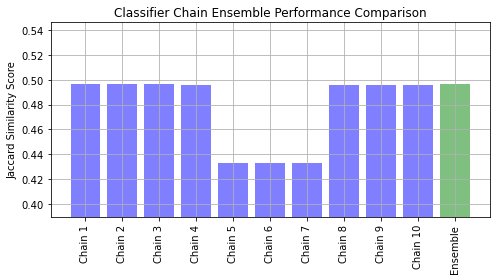

In [119]:
model_scores = chain_jaccard_scores 
model_scores.append(ensemble_jaccard_score)
print(len(chain_jaccard_scores))
model_names = ("Chain 1", "Chain 2", "Chain 3", "Chain 4", "Chain 5", "Chain 6", "Chain 7", "Chain 8", "Chain 9", "Chain 10",\
               "Ensemble",)

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for each of the chains, and the ensemble 
fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["b"] * (len(chain_jaccard_scores)-1) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

In [120]:
r = weighted_log_loss(Y_val[:,1:], Y_pred_ensemble, class_counts_val)
print("The logloss of the Logistic Regression on validation is :",r.numpy())

The logloss of the Logistic Regression on validation is : 16.000952574499582


In [121]:
confusion_matrix(Y_val[:,0], np.argmax(Y_pred_ensemble, axis=1))

array([[2421,   59,    0,    0],
       [1639,   62,    0,    0],
       [ 745,   23,    0,    0],
       [  49,    2,    0,    0]], dtype=int64)

> 2.1. "Logistic Regression" (model baseline, with first 80/20 split and a weighted logloss).

In [114]:
weights = {0:1 ,1:10, 2:100, 3:1000}
clf = LogisticRegression(random_state=0, solver='saga', class_weight=weights, multi_class='multinomial',\
                        penalty='l1', max_iter=10000).fit(X_train, Y_train[:,0])

print("The accuracy of the Logistic Regression on train is :", clf.score(X_train, Y_train[:,0]))
print("The accuracy of the Logistic Regression on validation is :", clf.score(X_val, Y_val[:,0]))

The accuracy of the Logistic Regression on train is : 0.2325
The accuracy of the Logistic Regression on validation is : 0.2146


C:\Users\Ramzus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [115]:
r = weighted_log_loss(Y_train[:,1:], clf.predict_proba(X_train), class_counts_train)
print("The logloss of the Logistic Regression on train is :",r.numpy())
r = weighted_log_loss(Y_val[:,1:], clf.predict_proba(X_val), class_counts_val)
print("The logloss of the Logistic Regression on validation is :",r.numpy())

The logloss of the Logistic Regression on train is : 10.444228506552916
The logloss of the Logistic Regression on validation is : 11.41135720089699


In [116]:
print("The confusion matrix on train (x-axis: label, y-axis: prediction):")
display(confusion_matrix(Y_train[:,0], np.argmax(clf.predict_proba(X_train), axis=1)))
print("The confusion matrix on validation (x-axis: label, y-axis: prediction):")
display(confusion_matrix(Y_val[:,0], np.argmax(clf.predict_proba(X_val), axis=1)))

The confusion matrix on train (x-axis: label, y-axis: prediction):


array([[  54, 2914, 5033, 1596],
       [  15, 2547, 3706,  847],
       [   4,  684, 1992,  426],
       [   0,   26,   99,   57]], dtype=int64)

The confusion matrix on validation (x-axis: label, y-axis: prediction):


array([[  16,  779, 1290,  395],
       [   4,  553,  939,  205],
       [   2,  178,  491,   97],
       [   0,    9,   29,   13]], dtype=int64)

> 2.2 "Logistic Regression" (model baseline with a cross-validation (5 folds) and a weighted logloss).<br>

In [117]:
# A multinomial logistic regression model with a cross-validation 
model = LogisticRegression(random_state=0, solver='saga', class_weight=weights, multi_class='multinomial', penalty='l1',\
                          max_iter=1000)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_normalized, Y_target[:,0], scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
print('Score per fold = ', n_scores)

Mean Accuracy: 0.148 (0.075)
Score per fold =  [0.1658 0.161  0.0952 0.129  0.0274 0.1526 0.1902 0.0558 0.242  0.1372
 0.1472 0.0762 0.155  0.1392 0.3526]


<div class="alert alert-warning">
  <strong> Conclusion: </strong> <br>
    - The model using classifier chain predict only the classes 0 and 1. This could be explained by the imbalance in the dataset between the 4 classes. Then, the impact of the weighted log-loss aaproach could be seen through the results of the logistic regression examples. <br>
    - The model was tested first with all the variables as input and second with only the selected variables in order to verify the hypothesis of non nulti-colinearity of features before the application of the logistic regression. Better results were found with all the variables excluding only 3 variables ('date_request_year', 'date_global_year', 'fruit_situation_label_enc_freq', because of duplication of 'fruit_situation_label_enc_freq' and year variable is a almost non-changing variable). <br>
    - In general, the realized data engineering gives only low correlated variables to the target and this could be seen through the results of the model on the validation sample through the confusion matrix and the logloss measures (not significantly varying between developed models). <br>
    - Neural network model was explored but not documented here (the low disciminatory power do not give satisfactory results). <br>
 <strong> Perspectives: </strong> <br>
    - The feature engineering and feature selection could be improved. For instance, the features selectionn could be done using advanced methods like MRMR, CMIM or Boruta. <br> 
    - Hyperparameter-optimization lacks some deep analysis. For example, methods like grid search or random search could be done on the hyperparameters of the developed models.<br> 
    - The explainanbility of the model was not explored in this excercice. Feature importance, Shapley values or other metrics cuold be calculated.
</div>


<div class="alert alert-block alert-info">
    <em>Part 5: </em> <strong> Predictions computing for test sample.</strong>
</div>

In [143]:
list_vars = ['AP', 'situation', 'favorite_fruit', 'number_of_fruit',
           'green_vegetables', 'ville_enc_nan', 'fruit_situation_label_enc_nan',
           'ville_enc_freq', 'ctc__f', 'ctc__t', 'fruits_or_vegetables__f',
           'fruits_or_vegetables__t', 'vegetable_type__almostgreen',
           'vegetable_type__green', 'vegetable_type__notsogreen',
           'vegetable_type__prettygreen', 'vegetable_type__salad',
           'vegetable_type__verygreen', 'hobby__noball', 'hobby__volleyball',
           'gc_label_enc_freq', 'location_enc_freq', 'fruit_situation_id_enc_freq',
           'dates_diff', 'date_request_month', 'date_request_day',
           'date_request_weekday', 'date_request_hour', 'date_global_month',
           'date_global_day', 'date_global_weekday', 'date_global_hour']

In [148]:
list_columns_to_exclude = ['date_request_year', 'date_global_year', 'fruit_situation_label_enc_freq']
X_input = df_test_cleaned[list_vars]
#X_input = df_train_cleaned[selected_variables].values
X_test_normalized = normalizer.transform(X_input)
X_test_normalized


array([[ 0.        ,  0.81110419,  0.02703681, ...,  0.35147848,
         0.05407361,  0.18925764],
       [ 0.        , -0.02691895,  0.02691895, ...,  0.4845411 ,
         0.02691895,  0.4845411 ],
       [ 0.        , -0.00266847,  0.        , ...,  0.04536396,
         0.00533694,  0.03469008],
       ...,
       [ 0.        , -0.02941955,  0.        , ...,  0.79432788,
         0.0588391 ,  0.32361506],
       [ 0.        , -0.00487833,  0.        , ...,  0.04390494,
         0.01463498,  0.03902662],
       [ 0.        , -0.01429855,  0.        , ...,  0.44325501,
         0.0285971 ,  0.10008984]])

In [150]:
# train a new model using all the available data in train
weights = {0:1 ,1:10, 2:100, 3:1000}
clf = LogisticRegression(random_state=0, solver='saga', class_weight=weights, multi_class='multinomial',\
                        penalty='l1', max_iter=10000).fit(X_normalized, Y_target[:,0])

print("The accuracy of the Logistic Regression on train is :", clf.score(X_normalized, Y_target[:,0]))

The accuracy of the Logistic Regression on train is : 0.14904


C:\Users\Ramzus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [152]:
r = weighted_log_loss(Y_target[:,1:], clf.predict_proba(X_normalized), class_counts_all_train)
print("The logloss of the Logistic Regression on train is :",r.numpy())

The logloss of the Logistic Regression on train is : 4.6587608120091115


In [154]:
print("The confusion matrix on validation (x-axis: label, y-axis: prediction):")
display(confusion_matrix(Y_target[:,0], np.argmax(clf.predict_proba(X_normalized), axis=1)))

The confusion matrix on validation (x-axis: label, y-axis: prediction):


array([[2728,  160, 2146, 7043],
       [1279,  197, 1516, 5824],
       [ 350,   35,  622, 2867],
       [  20,    1,   33,  179]], dtype=int64)

In [169]:
predictions = clf.predict_proba(X_test_normalized)
df_predictions = pd.DataFrame(data=predictions, columns=[0, 1, 2, 3])  # 1st row as the column names
result = pd.concat([df_test[['id']], df_predictions], axis=1)
result

,id,0,1,2,3
0,cb7a4e0dd0777,7.510019e-169,0.000000e+00,1.137592e-73,1.000000e+00
1,e78e3915f3e30,1.339390e-253,0.000000e+00,3.703343e-250,1.000000e+00
2,8e65ba155f983,1.591120e-114,1.484270e-143,3.481681e-91,1.000000e+00
3,701e90ca03ce2,5.904223e-181,2.197526e-275,7.780789e-221,1.000000e+00
4,768fefec8609a,1.551307e-164,5.488917e-217,2.890113e-133,1.000000e+00
...,...,...,...,...,...
24995,3232bad9c00cc,1.000000e+00,7.917344e-111,8.238386e-35,0.000000e+00
24996,7b178c38ad263,9.647718e-12,4.373711e-13,6.029282e-54,1.000000e+00
24997,5876ad905d4b4,1.703887e-114,5.855580e-96,1.000000e+00,4.671328e-295
24998,5921ef2921c68,1.021831e-154,3.285641e-201,9.272488e-128,1.000000e+00


In [167]:
result.to_csv('./output/test_y_submission_Ramzi_CHAABEN.csv')

<div class="alert alert-block alert-success">
    <em>Case Study: </em> <strong>That's it. Thank you ^_^</strong>
</div>